In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset = fetch_ucirepo(id=887) 
  
# data (as pandas dataframes) 
X = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.features 
y = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.targets 
  
# metadata 
print(national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.metadata) 
  
# variable information 
print(national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.variables) 


{'uci_id': 887, 'name': 'National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset', 'repository_url': 'https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset', 'data_url': 'https://archive.ics.uci.edu/static/public/887/data.csv', 'abstract': "The National Health and Nutrition Examination Survey (NHANES), administered by the Centers for Disease Control and Prevention (CDC), collects extensive health and nutritional information from a diverse U.S. population. Though expansive, the dataset is often too broad for specific analytical purposes. In this sub-dataset, we narrow our focus to predicting respondents' age by extracting a subset of features from the larger NHANES dataset. These selected features include physiological measurements, lifestyle choices, and biochemical markers, which were hypothesized to have strong correlations with age.", 'area': 'Health and Medicine', 'tasks': ['Classifi

In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# 1) Load dataset
# -----------------------------
dataset = fetch_ucirepo(id=887)

X = dataset.data.features.values.astype(np.float32)
y = dataset.data.targets.values.ravel()   # flatten to 1D

# Convert categorical target labels (e.g., 'Graduate') into integers (0,1,2)
le = LabelEncoder()
y = le.fit_transform(y)

num_classes = len(np.unique(y))
print("Number of classes:", num_classes)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Number of classes: 2
Class mapping: {'Adult': np.int64(0), 'Senior': np.int64(1)}


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert targets to numpy arrays explicitly (fix for TensorDataset)
y_train = np.array(y_train, dtype=np.int64)
y_val   = np.array(y_val, dtype=np.int64)
y_test  = np.array(y_test, dtype=np.int64)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

In [6]:
train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val).long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test).long()
)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [7]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes)  # num_classes = 3 (Dropout, Enrolled, Graduate)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
def evaluate(loader):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count

epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_count += xb.size(0)

    train_epoch_loss = running_loss / running_count
    train_epoch_acc  = running_correct / running_count
    val_epoch_loss, val_epoch_acc = evaluate(val_loader)

    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    history['train_acc'].append(train_epoch_acc)
    history['val_acc'].append(val_epoch_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} "
              f"train_acc={train_epoch_acc:.4f} val_acc={val_epoch_acc:.4f}")


Epoch 01/50 | train_loss=0.4532 val_loss=0.4209 train_acc=0.8394 val_acc=0.8411
Epoch 05/50 | train_loss=0.3738 val_loss=0.3914 train_acc=0.8469 val_acc=0.8466
Epoch 10/50 | train_loss=0.3635 val_loss=0.3887 train_acc=0.8524 val_acc=0.8384
Epoch 15/50 | train_loss=0.3548 val_loss=0.3957 train_acc=0.8552 val_acc=0.8301
Epoch 20/50 | train_loss=0.3501 val_loss=0.4018 train_acc=0.8566 val_acc=0.8301
Epoch 25/50 | train_loss=0.3415 val_loss=0.4090 train_acc=0.8545 val_acc=0.8301
Epoch 30/50 | train_loss=0.3349 val_loss=0.4175 train_acc=0.8586 val_acc=0.8329
Epoch 35/50 | train_loss=0.3293 val_loss=0.4266 train_acc=0.8600 val_acc=0.8274
Epoch 40/50 | train_loss=0.3250 val_loss=0.4307 train_acc=0.8634 val_acc=0.8274
Epoch 45/50 | train_loss=0.3164 val_loss=0.4397 train_acc=0.8627 val_acc=0.8301
Epoch 50/50 | train_loss=0.3130 val_loss=0.4505 train_acc=0.8675 val_acc=0.8247


In [9]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       Adult       0.86      0.93      0.90       383
      Senior       0.39      0.22      0.28        73

    accuracy                           0.82       456
   macro avg       0.63      0.58      0.59       456
weighted avg       0.79      0.82      0.80       456



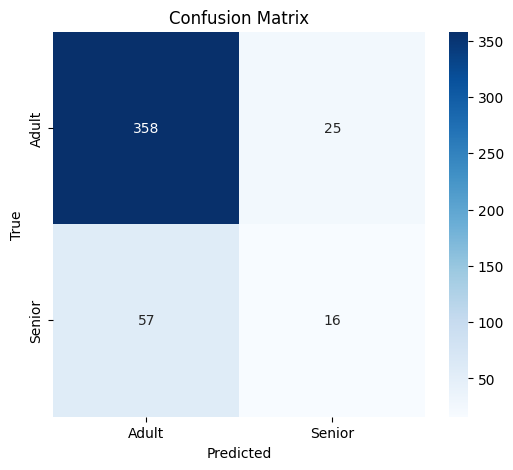

In [10]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


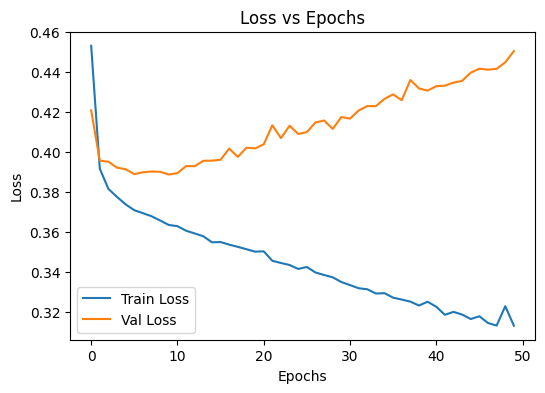

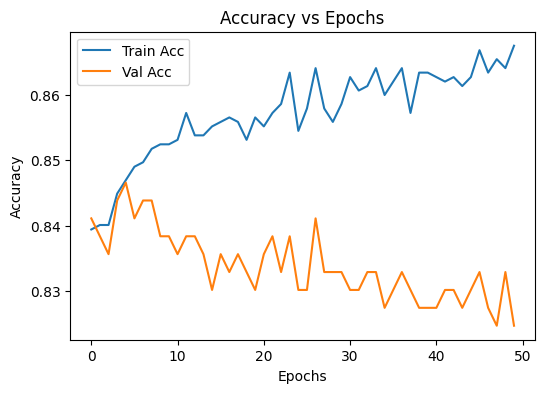

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()

In [15]:
# Convert numeric predictions back to original class names
decoded_preds = le.inverse_transform(all_preds)
decoded_true  = le.inverse_transform(all_true)

# Create a DataFrame to inspect
results_df = pd.DataFrame({
    'True Label': decoded_true,
    'Predicted': decoded_preds
})

# Show first 20 predictions
print(results_df.head(20))


   True Label Predicted
0       Adult     Adult
1       Adult     Adult
2      Senior     Adult
3      Senior     Adult
4       Adult     Adult
5       Adult     Adult
6      Senior    Senior
7      Senior    Senior
8       Adult     Adult
9       Adult     Adult
10      Adult     Adult
11      Adult     Adult
12      Adult     Adult
13     Senior     Adult
14      Adult     Adult
15      Adult     Adult
16      Adult     Adult
17      Adult     Adult
18      Adult     Adult
19      Adult     Adult


In [16]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_true.extend(yb.numpy())


In [19]:
# Decode numeric labels back to original class names
decoded_preds = le.inverse_transform(all_preds)
decoded_true  = le.inverse_transform(all_true)

# Create results DataFrame
import pandas as pd
results_df = pd.DataFrame({
    'True Label': decoded_true,
    'Predicted': decoded_preds
})

# Add a "Correct" column (True if prediction matches label, else False)
results_df['Correct'] = results_df['True Label'] == results_df['Predicted']

print(results_df.head(20))  # sanity check


   True Label Predicted  Correct
0       Adult     Adult     True
1       Adult     Adult     True
2      Senior     Adult    False
3      Senior     Adult    False
4       Adult     Adult     True
5       Adult     Adult     True
6      Senior    Senior     True
7      Senior    Senior     True
8       Adult     Adult     True
9       Adult     Adult     True
10      Adult     Adult     True
11      Adult     Adult     True
12      Adult     Adult     True
13     Senior     Adult    False
14      Adult     Adult     True
15      Adult     Adult     True
16      Adult     Adult     True
17      Adult     Adult     True
18      Adult     Adult     True
19      Adult     Adult     True


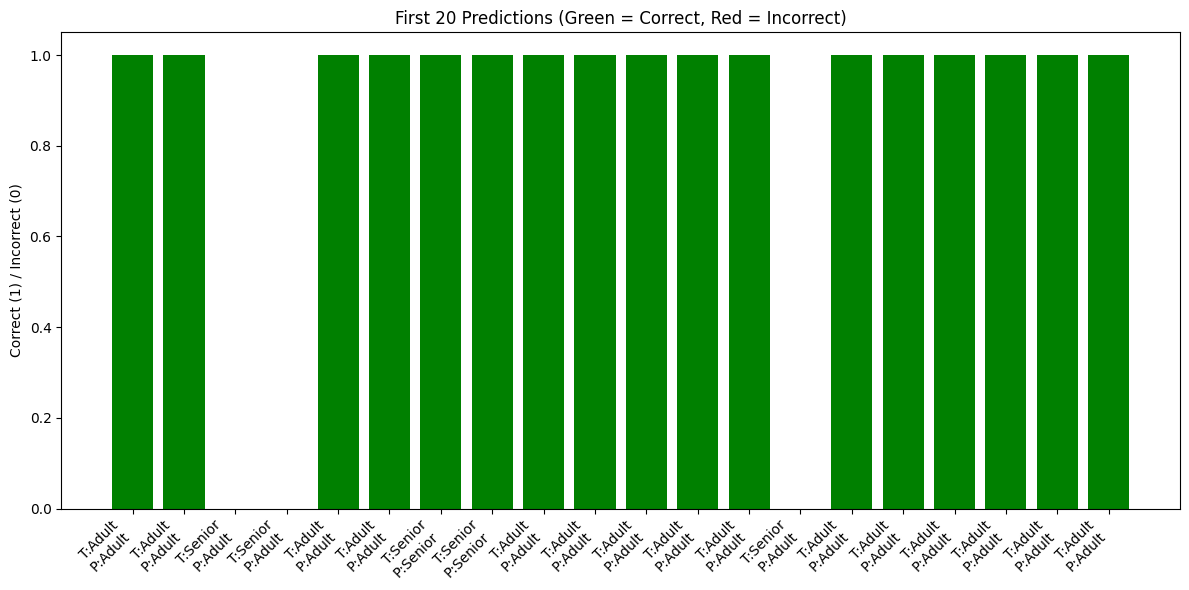

In [20]:
import matplotlib.pyplot as plt

# Take first 20 results
sample_results = results_df.head(20).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(sample_results)), 
               [1 if c else 0 for c in sample_results['Correct']], 
               color=['green' if c else 'red' for c in sample_results['Correct']])

plt.xticks(range(len(sample_results)), 
           [f"T:{t}\nP:{p}" for t, p in zip(sample_results['True Label'], sample_results['Predicted'])], 
           rotation=45, ha="right")

plt.title("First 20 Predictions (Green = Correct, Red = Incorrect)")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.tight_layout()
plt.show()
